# Basic Setup

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from google.colab import files

import tensorflow as tf
from tensorflow.keras import layers, Model

In [5]:
!unzip -qq images.zip # Unzipping the image file

In [6]:
df = pd.read_csv('mapping.csv') # Reading the mapping file
df

,file_name,captcha
0,1.png,p5g5m
1,2.png,e72cd
2,3.png,pgmn2
3,4.png,6cm6m
4,5.png,68wfd
...,...,...
1065,1066.png,ggd7m
1066,1067.png,de45x
1067,1068.png,b28g8
1068,1069.png,6p7gx


# Preprocessing data

In [39]:
# Getting the list of all the images
images = "/content/images/" + df["file_name"] # "/content/images/1.png" for eg
labels = df["captcha"]  # Stores all the captchas
characters = set(char for label in labels for char in label)  # Stores all the unique characters in the captchas
characters = "".join(sorted(list(characters))) # Sorts the list of unique characters
n = len(images)
n_char = len(characters)

print("Number of images found: ", n)
print("Number of labels found: ", n)
print("Number of unique characters: ", n_char)
print("Characters present: ", characters)

Number of images found:  1070
Number of labels found:  1070
Number of unique characters:  19
Characters present:  2345678bcdefgmnpwxy


In [10]:
images

0          /content/images/1.png
1          /content/images/2.png
2          /content/images/3.png
3          /content/images/4.png
4          /content/images/5.png
                  ...           
1065    /content/images/1066.png
1066    /content/images/1067.png
1067    /content/images/1068.png
1068    /content/images/1069.png
1069    /content/images/1070.png
Name: file_name, Length: 1070, dtype: object

In [11]:
labels

0       p5g5m
1       e72cd
2       pgmn2
3       6cm6m
4       68wfd
        ...  
1065    ggd7m
1066    de45x
1067    b28g8
1068    6p7gx
1069    gfp54
Name: captcha, Length: 1070, dtype: object

In [31]:
IMG_SIZE = (50, 200, 1) # Height 50, width 200, channel 1

In [110]:
def preprocess():
  X = np.zeros((n, 50, 200, 1))
  y = np.zeros((5, n, n_char))

  for i in range(n):
    image = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE)
    if(len(labels[i]) < 6):
      image = image / 255
      image = np.reshape(image, (50, 200, 1))
      target = np.zeros((5, n_char))
      # index stores the position of letter k of captcha in the character string
      for j, k in enumerate(labels[i]):
        index = characters.find(k)
        target[j, index] = 1  # replaces 0 with 1 in the target array at the position of the letter in captcha
      X[i] = image  #stores all the images
      y[:, i] = target  #stores all the info about the letters in captcha of all images
  return X, y

In [111]:
preprocess()

(array([[[[0.75294118],
          [0.75294118],
          [0.75294118],
          ...,
          [0.98431373],
          [0.98431373],
          [0.98431373]],
 
         [[0.75294118],
          [0.75294118],
          [0.75294118],
          ...,
          [0.98431373],
          [0.98431373],
          [0.98431373]],
 
         [[0.75294118],
          [0.75294118],
          [0.75294118],
          ...,
          [0.98431373],
          [0.98431373],
          [0.98431373]],
 
         ...,
 
         [[0.76470588],
          [0.76470588],
          [0.76470588],
          ...,
          [0.99607843],
          [0.99607843],
          [0.99607843]],
 
         [[0.76470588],
          [0.76470588],
          [0.76470588],
          ...,
          [0.99607843],
          [0.99607843],
          [0.99607843]],
 
         [[0.76470588],
          [0.76470588],
          [0.76470588],
          ...,
          [0.99607843],
          [0.99607843],
          [0.99607843]]],
 
 
        [

# Creating the model

In [134]:
def create_model():
  image_input = layers.Input(shape=IMG_SIZE)
  conv1 = layers.Conv2D(16, (3, 3), activation="relu", padding = "same", name="Conv1")(image_input)
  max1 = layers.MaxPool2D(padding="same", name="Pool1")(conv1)
  conv2 = layers.Conv2D(32, (3, 3), activation="relu", padding = "same", name="Conv2")(max1)
  max2 = layers.MaxPool2D(padding="same", name="Pool2")(conv2)
  conv3 = layers.Conv2D(32, (3, 3), activation="relu", padding = "same", name="Conv3")(max2)
  bn = layers.BatchNormalization(name = "Batch_Normalization")(conv3)
  max3 = layers.MaxPool2D(padding="same", name="Pool3")(bn)

  flat = layers.Flatten(name="Flatten")(max3)
  outs = []
  for i in range(5):  # For each letter of the captcha
    dense = layers.Dense(64, activation="relu", name=f"Dense1_{i}")(flat)
    drop = layers.Dropout(0.5, name=f"Dropout_{i}")(dense)
    dens = layers.Dense(n_char, activation = "sigmoid", name=f"Dense2_{i}")(drop)

    outs.append(dens) # Result of all the nodes

  # Compile model and return it
  model = Model(image_input, outs) #create model
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
  return model

In [135]:
model = create_model()
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 50, 200, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 50, 200, 16)          160       ['input_13[0][0]']            
                                                                                                  
 Pool1 (MaxPooling2D)        (None, 25, 100, 16)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 25, 100, 32)          4640      ['Pool1[0][0]']               
                                                                                            

# Splitting the data into train, test and validation datasets

In [136]:
X, y = preprocess()

In [137]:
#split the 1070 samples where 970 samples will be used for training purpose
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [138]:
X_train.shape

(970, 50, 200, 1)

# Training the model

In [139]:
#Applying the model
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=60, validation_split=0.2)
#batch size- 32 defines no. of samples per gradient update
#Validation split=0.2 splits the training set in 80-20% for training nd testing

Epoch 1/60
25/25 [==============================] - 13s 316ms/step - loss: 15.4661 - Dense2_0_loss: 3.1019 - Dense2_1_loss: 3.1120 - Dense2_2_loss: 3.1298 - Dense2_3_loss: 3.0971 - Dense2_4_loss: 3.0253 - Dense2_0_accuracy: 0.0747 - Dense2_1_accuracy: 0.0722 - Dense2_2_accuracy: 0.0593 - Dense2_3_accuracy: 0.0554 - Dense2_4_accuracy: 0.0941 - val_loss: 14.7172 - val_Dense2_0_loss: 2.9435 - val_Dense2_1_loss: 2.9403 - val_Dense2_2_loss: 2.9440 - val_Dense2_3_loss: 2.9433 - val_Dense2_4_loss: 2.9461 - val_Dense2_0_accuracy: 0.0876 - val_Dense2_1_accuracy: 0.0361 - val_Dense2_2_accuracy: 0.0412 - val_Dense2_3_accuracy: 0.0722 - val_Dense2_4_accuracy: 0.0619
Epoch 2/60
25/25 [==============================] - 9s 360ms/step - loss: 14.6728 - Dense2_0_loss: 2.9331 - Dense2_1_loss: 2.9290 - Dense2_2_loss: 2.9316 - Dense2_3_loss: 2.9422 - Dense2_4_loss: 2.9369 - Dense2_0_accuracy: 0.0760 - Dense2_1_accuracy: 0.0722 - Dense2_2_accuracy: 0.0747 - Dense2_3_accuracy: 0.0941 - Dense2_4_accuracy: 0.

# Prediction Function

In [166]:
def predict(image_path):
  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  if image is not None:
    image = image / 255
    image = np.reshape(image, (50, 200, 1))
    print(image.shape)
  else:
    "Image not found!"

  result = model.predict(image[np.newaxis, :, :, np.newaxis])#np.newaxis=1
  result = np.reshape(result, (5, n_char)) #reshape the array

  k_ind = []
  for k in result:
    k_ind.append(np.argmax(k))

  captcha = ""
  for k in k_ind:
    captcha += characters[k]

  plt.imshow(image, cmap="gray")
  plt.title("Prediction: " + str(captcha))
  plt.show()
  return captcha

# User Input and Testing

In [169]:
image = files.upload()

Saving 5.png to 5.png


In [172]:
name = ''
for i in image:
  name = i
print(type(name))
name

<class 'str'>


'5.png'

(50, 200, 1)
1/1 [==============================] - 0s 66ms/step


'68wfd'

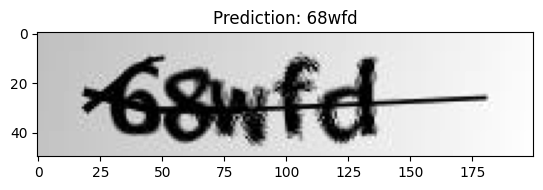

In [174]:
predict(name)